<a href="https://colab.research.google.com/github/xwen1765/HMM_Neuro/blob/main/HMM_Neuro.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d
from scipy.stats import zscore
from sklearn.decomposition import PCA
plt.rcParams['figure.dpi'] = 175
np.set_printoptions(threshold=np.inf)

In [2]:
# @title Data retrieval
import os, requests

fname = []
for j in range(3):
  fname.append('steinmetz_part%d.npz'%j)
url = ["https://osf.io/agvxh/download"]
url.append("https://osf.io/uv3mw/download")
url.append("https://osf.io/ehmw2/download")

for j in range(len(url)):
  if not os.path.isfile(fname[j]):
    try:
      r = requests.get(url[j])
    except requests.ConnectionError:
      print("!!! Failed to download data !!!")
    else:
      if r.status_code != requests.codes.ok:
        print("!!! Failed to download data !!!")
      else:
        with open(fname[j], "wb") as fid:
          fid.write(r.content)

In [3]:
# @title Data loading
alldat = np.array([])
for j in range(len(fname)):
  alldat = np.hstack((alldat,
                      np.load('steinmetz_part%d.npz'%j,
                              allow_pickle=True)['dat']))

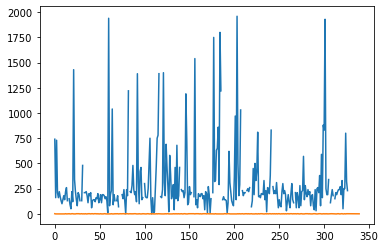

In [4]:
#plot the reaction_time data for a given session
dat = alldat[11]

#print(dat['reaction_time'])
plt.plot(dat['reaction_time'])

## Extracting the index and spiking activity of all neurons from a given brain region.

In [5]:
def cells_region_all_sessions(alldat, region):
  '''
  Given a brain region, returns the index and spiking activity
  vectors of all neurons recorded in that brain region, across
  all sessions.

  Arguments:
  ----------
  alldat: np.ndarray
    All the data from all sessions.

  region: str
    The region of interest (must match entries in 'brain_area'.)

  Returns:
  --------
  cell_indices: list
    For each cell, a list of length 2 indicating the session index
    ([0]) and intra-session cell index corresponding to this cell.

  cell_spiking: np.ndarray
    The trial-by-trial spiking activity vectors for this cell.
  '''
  cell_indices = []
  for ind, session in enumerate(alldat):
    cells = np.where(session['brain_area'] == region)[0]
    for cell in cells:
      cell_indices.append([ind, cell])

  cell_spiking = np.empty(len(cell_indices), dtype=np.ndarray)
  for ind, cell in enumerate(cell_indices):
    cell_spiking[ind] = alldat[cell[0]]['spks'][cell[1]]

  return cell_indices, cell_spiking

812 neurons from ORB region.


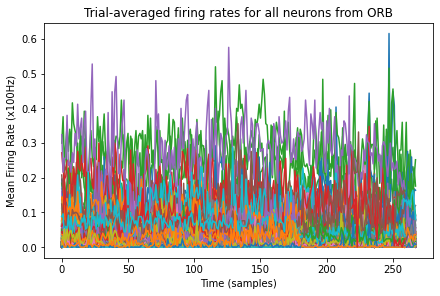

In [6]:
fig, ax = plt.subplots(1,1, constrained_layout=True)

region = 'ORB'
indices, spiking = cells_region_all_sessions(alldat, region)
print(f'{len(indices)} neurons from {region} region.')

mean_cell_spiking = np.empty(len(spiking), dtype=np.ndarray)

for ind, cell in enumerate(spiking):
  mean_cell_spiking[ind] = np.mean(cell, axis=1)
  ax.plot(mean_cell_spiking[ind])

ax.set_title(f'Trial-averaged firing rates for all neurons from {region}')
ax.set_xlabel('Time (samples)')
ax.set_ylabel('Mean Firing Rate (x100Hz)')
plt.show()

##Z-score normalization for firing rates.

In [7]:
def z_score(spiking, baseline=50):
  '''
  Calculates Z-scored firing rates, based on a defined
  baseline period.

  Arguments:
  ----------
  spiking: np.ndarray
    A spiking activity vector, with 0/1 for each timepoint.

  baseline: int, default=50
    The end of the baseline period at the start of the vector.

  Returns:
  --------
  z_scored_firing: np.ndarray
    A vector of same length as spiking, but with z-score normalization.
  '''
  baseline_spiking = spiking[0:baseline]
  mean = np.mean(baseline_spiking)
  sd = np.std(baseline_spiking)

  return (spiking-mean)/sd

1118 neurons from VISp region.


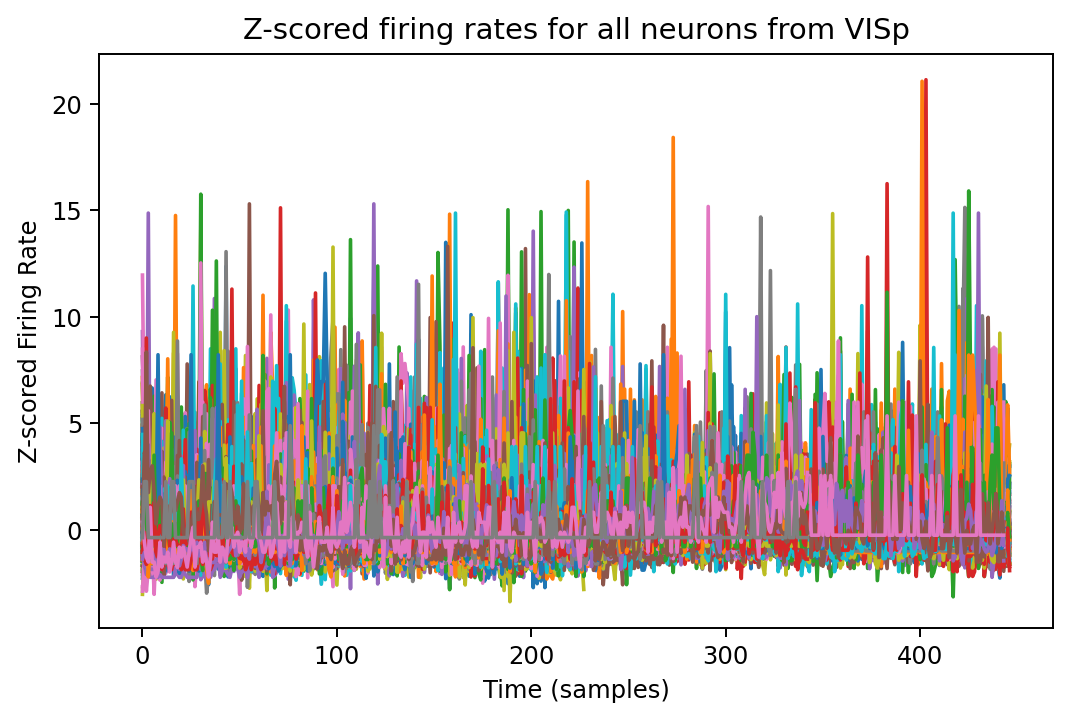

In [ ]:
fig, ax = plt.subplots(1,1, constrained_layout=True)
region = 'VISp'
indices, spiking = cells_region_all_sessions(alldat, region)
print(f'{len(indices)} neurons from {region} region.')

zscore_spiking = np.empty(len(spiking), dtype=np.ndarray)

for ind, cell in enumerate(spiking):
  zscore_spiking[ind] = zscore(np.mean(cell, axis=1))
  ax.plot(zscore_spiking[ind])

ax.set_title(f'Z-scored firing rates for all neurons from {region}')
ax.set_xlabel('Time (samples)')
ax.set_ylabel('Z-scored Firing Rate')
plt.show()

## Concatenate behavioral data across all trials

In [10]:
def all_sessions(alldat, key, index=0):
  '''
  Concatenates data from multiple sessions into a single 1D vector.
  Must be one data point per trial (i.e. reaction time, response, etc)

  Arguments:
  ----------
  alldat: np.ndarray
    Contains all data for all sessions

  key: str
    The dict key (e.g. 'response') of the desired data.

  index: int
    For data channels that have an array/list for each trial, specifies the 
    index from that list that should be used.

  Returns:
  --------
  data: np.ndarray
    A 1D vector containing the contenated data across all sessions, ordered by
    session index.
  '''
  data = np.array([])
  for session in alldat:
    if (type(session[key][0]) == np.ndarray
        or type(session[key][0]) == list):
        new_data = np.array([i[index] for i in session[key]])

    else:
      new_data = session[key]
    data = np.concatenate([data, new_data])
  return data

def mouse_sessions(alldat, key, index=0):
  '''
  Returns a nested numpy array containing all data (of a given type),
  concatenated across sessions.
  '''
  names = np.unique([i['mouse_name'] for i in alldat])
  mouse_data = np.empty(len(names), dtype=np.ndarray)
  session_lengths = np.empty_like(mouse_data)

  for ind, mouse in enumerate(names):
    mouse_data[ind] = np.array([])
    session_lengths[ind] = np.array([])
    for session in alldat:
      if session['mouse_name'] == mouse:
        mouse_data[ind] = np.concatenate([mouse_data[ind], session[key]])
        session_lengths[ind] = np.append(session_lengths[ind], int(len(session[key])))

  return mouse_data, names, session_lengths

def get_mouse_ids(alldat):
  '''
  Returns a vector of same length as all trials in the dataset, with the mouse
  ID for each trial.
  '''
  mouse_names = np.array(['Cori', 'Forssmann', 'Hench', 'Lederberg', 'Moniz', 'Muller',
                 'Radnitz', 'Richards', 'Tatum', 'Theiler'])
  mouse_ids = np.array([], dtype=np.int8)

  for session in alldat:
    mouse_ind = np.where(session['mouse_name'] == mouse_names)[0]
    n_trials = len(session['response'])
    new_ids = np.ones(n_trials) * mouse_ind
    mouse_ids = np.append(mouse_ids, new_ids)

  return mouse_ids.astype(np.int8)

mouse_ids = get_mouse_ids(alldat)
print(len(mouse_ids))

10050


## Testing the HMM model

In [11]:
!pip install hmmlearn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 129 kB 14.2 MB/s 


In [12]:
from hmmlearn import hmm

choices, names, session_lengths = mouse_sessions(alldat, 'response')

mouse = 1

n_components = 2 # Number of possible states

model = hmm.MultinomialHMM(n_components=n_components,
        n_iter=50,
        random_state=1,
        init_params='ste')

choice_array = np.empty((len(choices[mouse]), 1), dtype=int)
choice_array[:,0] = choices[mouse] + 1 # Adding 1 so that all choices are positive

model.n_features = len(np.unique(choice_array)) # Number of possible choices
model.fit(choice_array, session_lengths[mouse].astype(int))
log_prob, state_sequence = model.decode(choice_array, 
                                        session_lengths[mouse].astype(int))

Text(0.5, 0, 'Choice')

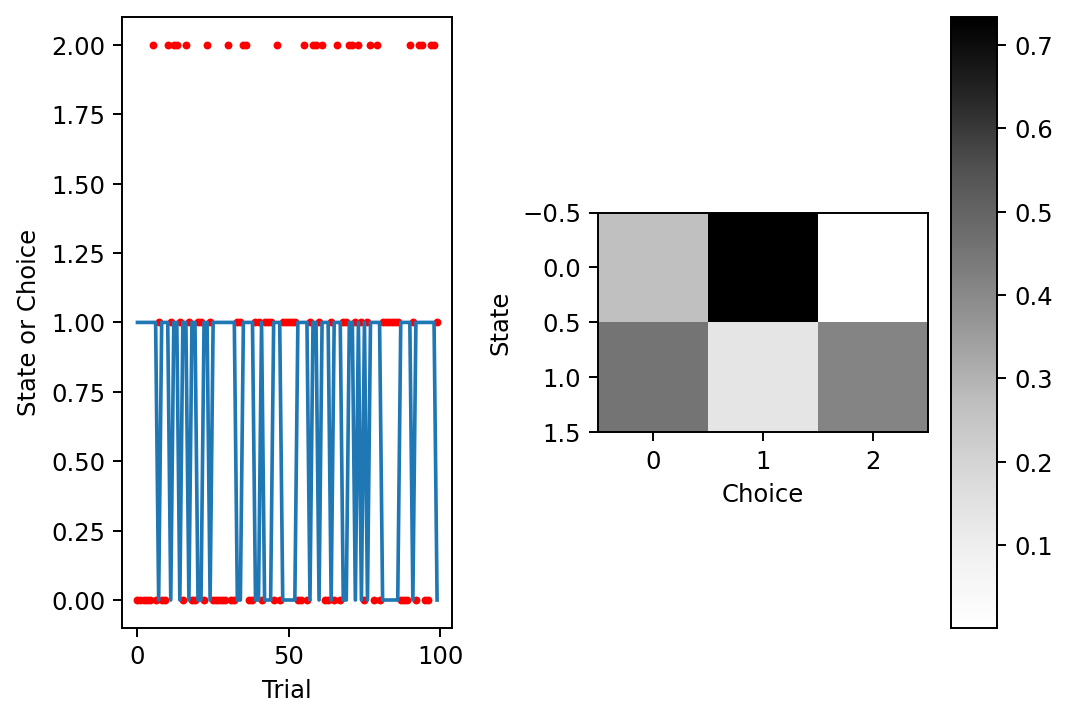

In [13]:
plt.rcParams['figure.dpi'] = 175
fig, axs = plt.subplots(1,2, constrained_layout=True)
axs[0].plot(state_sequence[0:100])
axs[0].scatter(np.arange(0,100), choice_array[0:100], color='r', s=5)
axs[0].set_ylabel('State or Choice')
axs[0].set_xlabel('Trial')

im = axs[1].imshow(model.emissionprob_, cmap='Greys')
plt.colorbar(im, ax=axs[1])
axs[1].set_ylabel('State')
axs[1].set_xlabel('Choice')

## Data for inputting to hDDM

In [16]:
import pandas as pd

df = pd.DataFrame()
df['mouse_name'] = get_mouse_ids(alldat)
df['contrast_difference'] = (all_sessions(alldat, 'contrast_left')
                             - all_sessions(alldat, 'contrast_right')).astype(np.float16)
df['response'] = all_sessions(alldat, 'response').astype(np.int8)
df['reaction_time'] = all_sessions(alldat, 'reaction_time').astype(np.float16)

print(df)
# Uncomment below to print df with all 10050 rows.
#print(df.to_string())

       mouse_name  contrast_difference  response  reaction_time
0               0                 1.00         1          170.0
1               0                -0.50        -1          230.0
2               0                 0.50         1          200.0
3               0                 0.00         0          860.0
4               0                -0.50         1          140.0
...           ...                  ...       ...            ...
10045           9                 0.75         0            inf
10046           9                 0.75        -1         1000.0
10047           9                 0.75         0            inf
10048           9                 0.75         0            inf
10049           9                 0.75         0            inf

[10050 rows x 4 columns]


In [ ]:
score, sequence  = model.decode(choice_array, session_lengths[mouse].astype(int));
#print(score)
#plt.plot(sequence[0:100])

feedback, names, session_lengths = mouse_sessions(alldat, 'feedback_type')
reward_1 = np.mean(feedback[mouse][np.where(sequence==0)])
reward_2 = np.mean(feedback[mouse][np.where(sequence==1)])
#reward_3 = np.mean(feedback[mouse][np.where(sequence==2)])
#reward_4 = np.mean(feedback[mouse][np.where(sequence==3)])
print(reward_1, reward_2)
print(len(feedback[mouse][np.where(sequence==0)]), len(feedback[mouse][np.where(sequence==1)]))

0.044897959183673466 0.4419642857142857
245 448


In [ ]:
all_scores = list() 
all_models = list()
for mouse in range (len(choices)):
  scores = list()
  models = list()
  for n_components in range(2, 6):
      for idx in range(10):  # ten different random starting states
          # define our hidden Markov model
          model = hmm.MultinomialHMM(n_components=n_components, random_state=idx,
                                n_iter=50)
          new_array = np.empty((len(choices[mouse]), 1), dtype=int)
          new_array[:,0] = choices[mouse] + 1

          model.n_features = n_features
          model.fit(new_array, session_lengths[mouse].astype(int))
          models.append(model)
          scores.append(model.score(new_array, session_lengths[mouse].astype(int)))
          #print(f'Converged: {model.monitor_.converged}\t\t'
                #f'Score: {scores[-1]}')
          
  # get the best model
  model = models[np.argmax(scores)]
  print(f'The best model had a score of {max(scores)} and '
        f'{model.n_components} components')
  all_scores.append(model.score(new_array, session_lengths[mouse].astype(int)))
  all_models.append(model)
  
mice = np.arange(0,len(choices))
normalized_scores = all_scores / all_scores.mean(0)
plt.bar(mice, normalized_scores, tick_label=mice);